## Image classification (single label)

Each image has one given label ("effusion", "normal")

Documentation:

Creating a dataset, training:
https://towardsdatascience.com/image-classification-using-fastai-v2-on-colab-33f3ebe9b5a3

Training, prediction + interpretation:
https://docs.fast.ai/tutorial.medical_imaging.html

In [1]:
# When I want to close any Google Colab project, before 
# I have to finish all the opened sessions 
# (go to Entorno de ejecucion > Gestionar sesiones)
# After finishing all the sesions I've to
# select None as execution environment 

# The next lines should be uncommented only when loading a new execution environment (GPU/TPU)
# NOTE: uncomment next lines when running this notebook on Drive
#from google.colab import drive
#drive.mount('/content/drive')


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # 0 = id of the gpu
# To know which id have to be set on the previous line, on Windows 10 run "nvidia-smi" on CMD to check all the installed GPUs data, like
# the id, driver version and CUDA version 

# Check if your GPU driver and CUDA is enabled and is accessible by PyTorch
# TO USE CUDA SELECT A GPU ON THE EXECUTION ENVIRONMENT, NOT A TPU
import torch; print(torch.version.cuda) # the CUDA version must be printed
print(torch.cuda.is_available()) # True must be printed (if False press on the Restart button at the top of the notebook)
print(torch.cuda.current_device()) # the id of the GPU must be printed

11.3
True
0


In [4]:
# Uncomment next line if "from fastai.vision.all import *" returns error
#!pip install fastai --upgrade # NOTE: uncomment on Drive 

from fastai.vision.all import *
from fastai.vision import *
from fastai.metrics import accuracy
#from torch.nn import L1Loss
from skimage.util import montage
import numpy as np

## Getting and converting the data

In [5]:
# Get the path of the dataset  

path = 'dataset/train_test' # ignore the validation set (just use the train_test)

# dataset source - https://www.kaggle.com/epreis/rxtorax 

## Creating a dataset

In [6]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # CategoryBlock = label
    get_items=get_image_files,
    get_y= parent_label, # parent_label = the folders names of the images are the labels
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # split training/validation; parameter 0.1 means there will be 10% of validation images 
    batch_tfms= [*aug_transforms(do_flip=False, size=(120,160)), Normalize.from_stats(*imagenet_stats)] 
)


In [7]:
path_dl = Path(path)
Path.BASE_PATH = path_dl
path_dl.ls().sorted()

(#4) [Path('effusion'),Path('models'),Path('normal'),Path('trained_effusion_classif_resnet_export.pkl')]

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


C:\Users\marcp\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\_tensor.py:1142: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:859.)
  ret = func(*args, **kwargs)


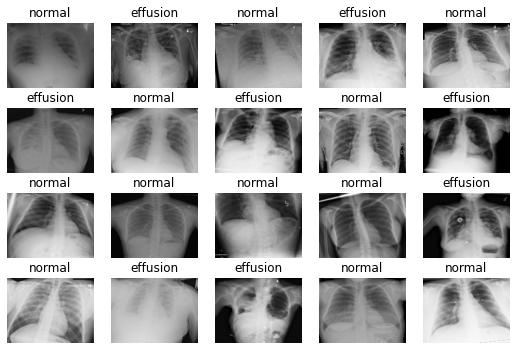

In [8]:
# Load the data and show a batch # NOTE: research to explain more properly what the 2 next lines do 

dls = data.dataloaders(path_dl, path=path_dl, bs = 64) # bs: how many samples per batch to load 
# If your GPU doesn't have enough memory and you can't run the whole notebook, 
# reduce the bs parameter value to, for example, 16 or 8
# and press the Restart button at the top of the notebook to empty the used memory

dls.show_batch(max_n=20, figsize=(9,6)) # NOTE: what do the values of figsize represent?
# NOTE: The batch shown contains validation and training images?

In [9]:
# Checks the labels using vocab

dls.vocab

['effusion', 'normal']

In [10]:
# Show the list of validation images

# Next line from the original code is commented because it returns error ('DataBlock' object has no attribute 'valid_ds')
# data.valid_ds.items
# Instead of data.valid_ds.items it should be dls.valid_ds.items 
dls.valid_ds.items

[Path('effusion/effusion482.png'),
 Path('normal/normal393.png'),
 Path('effusion/effusion277.png'),
 Path('effusion/effusion202.png'),
 Path('normal/normal482.png'),
 Path('effusion/effusion50.png'),
 Path('normal/normal363.png'),
 Path('effusion/effusion338.png'),
 Path('normal/normal370.png'),
 Path('effusion/effusion374.png'),
 Path('effusion/effusion354.png'),
 Path('effusion/effusion480.png'),
 Path('effusion/effusion446.png'),
 Path('effusion/effusion100.png'),
 Path('normal/normal256.png'),
 Path('normal/normal346.png'),
 Path('effusion/effusion59.png'),
 Path('normal/normal409.png'),
 Path('effusion/effusion223.png'),
 Path('normal/normal476.png'),
 Path('normal/normal135.png'),
 Path('effusion/effusion13.png'),
 Path('effusion/effusion22.png'),
 Path('effusion/effusion350.png'),
 Path('effusion/effusion201.png'),
 Path('normal/normal191.png'),
 Path('normal/normal155.png'),
 Path('effusion/effusion194.png'),
 Path('normal/normal313.png'),
 Path('normal/normal10.png'),
 Path('

## Train model



In [11]:
# Create a CNN learner using resnet34
# Which architecture should we use?: 
# Check: https://theaisummer.com/cnn-architectures/
# According to the previous doc, a priori resnet50 presents higher accuracy than e.g. resnet34, resnet18

# A Leaner is a trainer for model using data (dls) to minimize the loss
learn = cnn_learner(dls, resnet34, metrics=accuracy)

#print(learn.summary()) # Show model layers data 

#learn.load('effusion_classification_stage-1')
# If we have a saved model with the right accuracy, we can load it without having to train it again
# We can load a saved model by adding "learn.load(name of the model)" after "learn" has been initialized
# Then we have to comment all the following functions until the Data Augmentation cell
# because they had been previously executed on the loaded model

### 1st training (without unfreezing)

SuggestedLRs(valley=0.0014454397605732083)

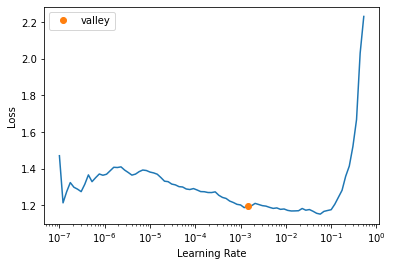

In [12]:
# Find a suitable learning rate

learn.lr_find()

In [13]:
# Train the model using fit_one_cycle

learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,accuracy,time
0,1.333856,0.834146,0.550505,00:10
1,1.250742,0.692663,0.661616,00:10
2,1.154799,0.760668,0.696970,00:10
3,1.068530,0.865803,0.656566,00:10
4,1.003528,0.918133,0.646465,00:10
5,0.952817,1.001580,0.676768,00:10
6,0.918185,1.109855,0.641414,00:11
7,0.911536,1.075223,0.681818,00:10
8,0.870100,1.229431,0.707071,00:10
9,0.847030,0.992243,0.707071,00:10


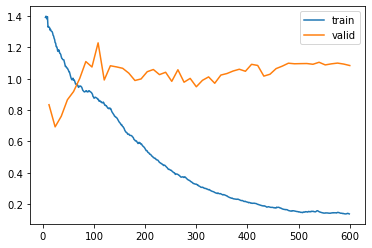

In [14]:
learn.recorder.plot_loss() 

### 2nd training (unfreeze the network)

In [15]:
# Now we can unfreeze the network and train the whole network

learn.unfreeze()
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,time
0,0.183701,1.213258,0.686869,00:12
1,0.181895,1.251856,0.727273,00:11
2,0.179818,1.235310,0.732323,00:11
3,0.170247,1.076089,0.742424,00:11
4,0.156856,1.532351,0.737374,00:11
5,0.161418,1.476832,0.752525,00:11
6,0.172156,1.499449,0.676768,00:11
7,0.180620,1.281457,0.732323,00:11
8,0.213530,1.604818,0.757576,00:11
9,0.223451,2.162407,0.702020,00:11


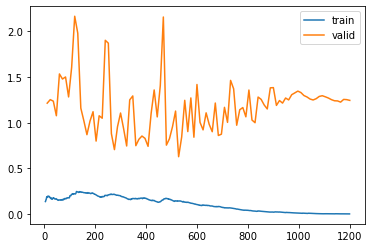

In [16]:
# Plot losses 

# If the model has been trained correctly train loss must be lower than validation loss.

learn.recorder.plot_loss() 
# X axis refers to the number of epochs 
# Y axis refers to the losses 

In [17]:
# Save the model 
learn.save('effusion_classification_stage-1')
# The file gets stored at the models folder that is a new folder created inside the dataset folder 

# We can load this model after "learn" is initialized by calling to "learn.load(roi_detector_stage-1)"

Path('models/effusion_classification_stage-1.pth')

In [18]:
# Use export function to save the Learner in dataset path/fname, using pickle_protocol. 
# Note that serialization in Python saves the names of functions, not the code itself. 
# Therefore, any custom code you have for models, data transformation, loss function etc... 
# should be put in a module that you will import in your training environment before exporting, 
# and in your deployment environment before loading it.
learn.export('trained_effusion_classif_export.pkl') # NOTE: what type of program can open a pkl file?
# The file gets stored at the dataset folder 

## Prediction

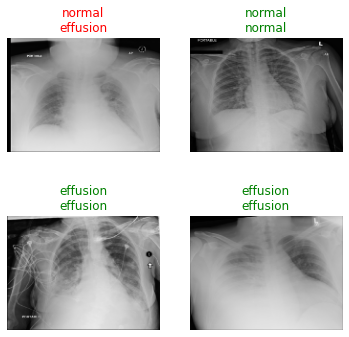

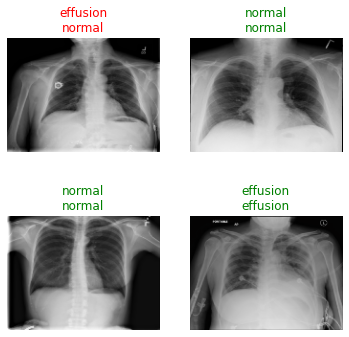

In [19]:
effusionTestPath = "dataset/validation/effusion/"
normalTestPath = "dataset/validation/normal/"

effusionTestImages = [testImage for testImage in os.listdir(effusionTestPath)]
normalTestImages = [testImage for testImage in os.listdir(normalTestPath)]

for effusionImage in effusionTestImages:
    imagePath = effusionTestPath + effusionImage
    learn.predict(imagePath) # NOTE: Try to make output disappear

# When predicting on an image learn.predict returns a tuple (class, class tensor and [probabilities of each class]).
# In this dataset there are only 2 classes "normal" and "effusion" hence the reason why each probability has 2 values,
# the first value is the probability whether the image belongs to class 0 or "effusion" and the second value is the probability 
# whether the image belongs to class 1 or "normal"

# Show the predictions results based on the effusion test images
learn.show_results(max_n=4) # max_n=4 because we have stored 4 effusion test images


for normalImage in normalTestImages:
    imagePath = normalTestPath + normalImage
    learn.predict(imagePath)

# Show the predictions results based on the effusion test images
learn.show_results(max_n=4) # max_n=4 because we have stored 4 normal test images

# 8 test images were given and according to the following output
# 6 predictions are right and 2 are wrong (6/8 = 75% accuracy) 

## Interpretation

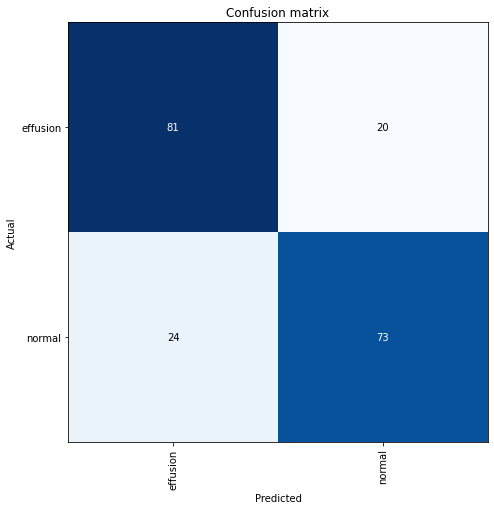

In [20]:
# Plot a confusion matrix 

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,7))

In [21]:
# Get the sensitivity (Sensitivity = True Positive/(True Positive + False Negative))

upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]

sensitivity = tp/(tp + fn)
sensitivity
# For example, if sensitivity is equal to 40% it means the model is only capable of correctly detecting 40% True Positives
# (i.e. who have Normal) but will miss 60% of False Negatives (patients that actually have Effusion but were told they did not! Not a good situation to be in).

0.7525773195876289

In [22]:
# Compute specificity

specificity = tn/(fp + tn)
specificity
# For example, if the model has a specificity of 63% and hence can correctly detect 63% of the time 
# that a patient does not have Effusion but will incorrectly classify that 37% of the patients have Effusion (False Postive) but actually do not.

0.801980198019802

In [23]:
# Positive Predictive Value (PPV), between 0 and 1

ppv = tp/(tp+fp)
ppv
# If ppv is low it means the model doesn't perform well in correctly predicting patients with Effusion
# If ppv is high it means the model predicts well the patients with Effusion

0.7849462365591398

In [24]:
# Negative Predictive Value (NPV)

npv = tn/(tn+fn)
npv
# If npv is low it means the model doesn't perform well in correctly predicting patients which don't have Effusion
# If npv is high it means the model predicts well the patients with Effusion

0.7714285714285715